## Image Processing for Transfer Learning 

 * Select Subset of Dataframe for glasses, hats, and beard one vs rest classifier 
 * split into train and test df for model training 
 * view images after keras_preprocessing.image ImageDataGenerator
---

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [3]:
# load dataframe
df_pics = pd.read_pickle('finished_pickles/pic_df.pkl')
df_pics.head(2)

,beard,hat,eyewear
00670.jpg,1,0,0
00691.jpg,1,0,0


In [4]:
glasses_df = df_pics.drop(columns = ['beard','hat'])
glasses_df.head(2)

,eyewear
00670.jpg,0
00691.jpg,0


In [5]:
# check the glass ratio
# 50% and 50% almost perfect class balance 
glasses_df.eyewear.value_counts(normalize = True)

1    0.51608
0    0.48392
Name: eyewear, dtype: float64

In [6]:
# turn 0 and 1 into string for flow_from_dataframe
glasses_df = glasses_df.eyewear.map({0:'Not_Glasses',1:'Glasses'})

In [7]:
# for flow_dataframe:
glasses_df = glasses_df.reset_index()

In [85]:
glasses_df.eyewear

0      Not_Glasses
1      Not_Glasses
2          Glasses
3      Not_Glasses
4          Glasses
5      Not_Glasses
6      Not_Glasses
7      Not_Glasses
8          Glasses
9      Not_Glasses
10     Not_Glasses
11     Not_Glasses
12     Not_Glasses
13     Not_Glasses
14         Glasses
15         Glasses
16         Glasses
17     Not_Glasses
18     Not_Glasses
19     Not_Glasses
20     Not_Glasses
21     Not_Glasses
22     Not_Glasses
23         Glasses
24     Not_Glasses
25     Not_Glasses
26         Glasses
27         Glasses
28     Not_Glasses
29     Not_Glasses
          ...     
623        Glasses
624    Not_Glasses
625    Not_Glasses
626    Not_Glasses
627        Glasses
628    Not_Glasses
629    Not_Glasses
630        Glasses
631        Glasses
632        Glasses
633        Glasses
634        Glasses
635        Glasses
636        Glasses
637        Glasses
638        Glasses
639        Glasses
640    Not_Glasses
641    Not_Glasses
642    Not_Glasses
643    Not_Glasses
644    Not_G

In [8]:
# split into X_train, X_test and concatenate for image generator 
X_train, X_test, y_train, y_test = train_test_split(glasses_df['index'], glasses_df.eyewear, stratify = glasses_df.eyewear,
                                                   random_state = 16, test_size = 0.2)

In [9]:
# split into train_test df 
train_df = pd.DataFrame({'pic':X_train,'eyewear':y_train})
train_df.shape

(522, 2)

In [10]:
test_df = pd.DataFrame({'pic':X_test, 'eyewear':y_test})
test_df.shape

(131, 2)

In [11]:
# data preprocess and data agumentation to help with small data set 
datagen=ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [95]:
# get all data from test and train split 
train = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=653,
    seed = 36,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')

test = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=653,
    seed = 36,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


In [96]:
# checkout some images 
X_train, y_train = next(train)
X_test, y_test = next(test)

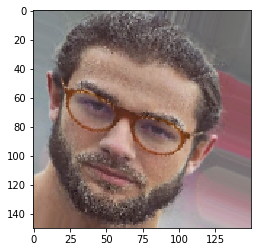

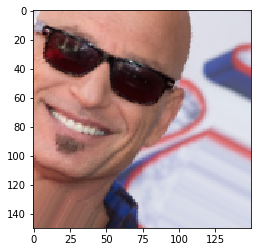

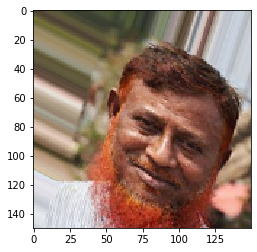

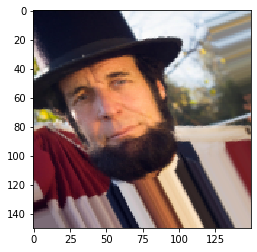

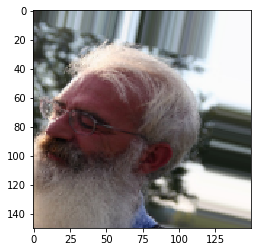

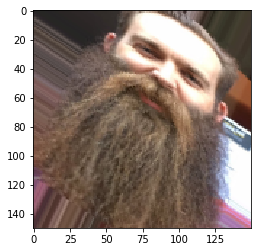

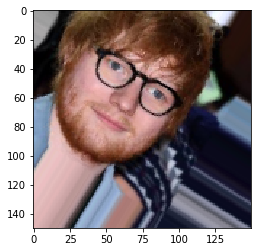

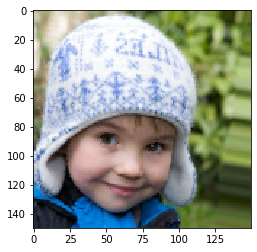

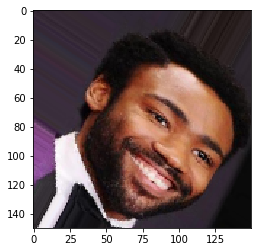

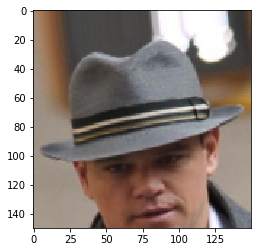

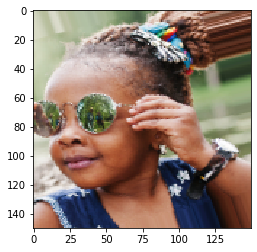

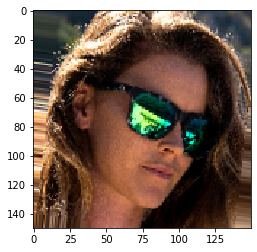

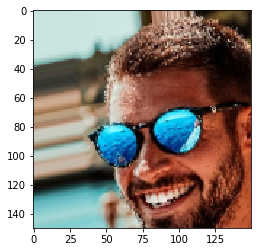

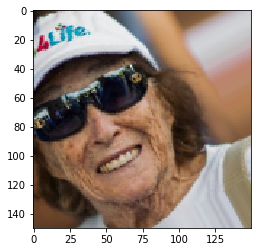

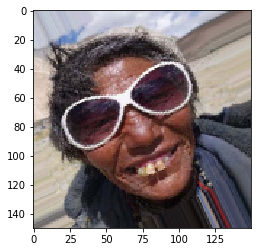

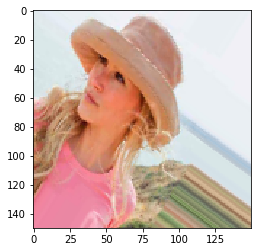

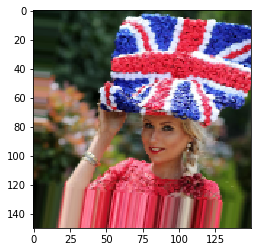

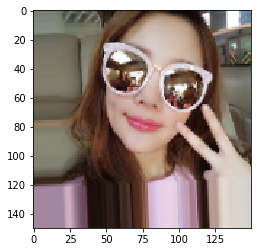

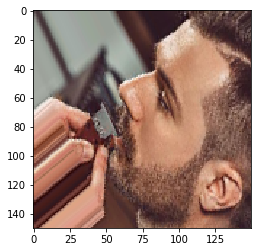

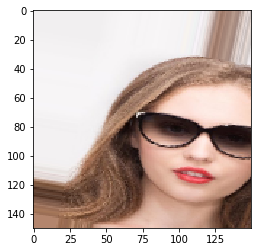

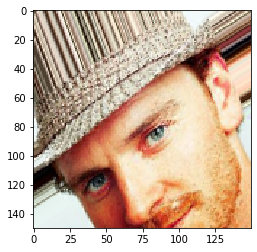

In [97]:
for i in range(65,86):
    plt.imshow(X_train[i])
    plt.show()

## Use Transfer Learning using vgg16

In [12]:
# intialize the model 
# make sure not to train the top layers 
model_vgg = VGG16(weights = 'imagenet', include_top = False)

W0827 22:41:16.567295 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 22:41:16.568161 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 22:41:16.570595 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 22:41:16.592151 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [13]:
epochs = 10
batch_size = 16

In [24]:
# train to get weights for fine tuning the model 
def save_bottleneck_features():
    train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_train = model_vgg.predict_generator(
        train_gen, 522//batch_size)
    np.save(open('bottleneck_model_weights/bottleneck_features_train.npy','wb'),
           bottleneck_features_train)
    
    test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_test = model_vgg.predict_generator(
        test_gen, 131//batch_size)
    np.save(open('bottleneck_model_weights/bottleneck_features_test.npy','wb'),
           bottleneck_features_test)

In [25]:
save_bottleneck_features()

Found 522 validated image filenames.
Found 131 validated image filenames.


In [20]:
# save train_test_df 
train_df.to_pickle('finished_pickles/train_df_glasses.pkl')
test_df.to_pickle('finished_pickles/test_df_glasses.pkl')